In [1]:
library(foreign)
library(ggplot2)
library(GGally)
library(survival)
library(rgl)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


### Examples of interval regression

### Description of the data

In [2]:
dat <- read.dta("./datasets/intreg_data.dta")

In [3]:
# summary of the variables
summary(dat)

       id             lgpa          ugpa           write           rating     
 Min.   : 1.00   Min.   :0.0   Min.   :2.000   Min.   : 50.0   Min.   :48.00  
 1st Qu.: 8.25   1st Qu.:2.0   1st Qu.:2.500   1st Qu.: 70.0   1st Qu.:51.62  
 Median :15.50   Median :2.5   Median :3.000   Median :105.0   Median :54.00  
 Mean   :15.50   Mean   :2.6   Mean   :3.097   Mean   :113.8   Mean   :57.53  
 3rd Qu.:22.75   3rd Qu.:3.3   3rd Qu.:3.700   3rd Qu.:153.8   3rd Qu.:66.25  
 Max.   :30.00   Max.   :3.8   Max.   :4.000   Max.   :205.0   Max.   :72.00  
         type   
 vocational: 8  
 general   :10  
 academic  :12  
                
                
                

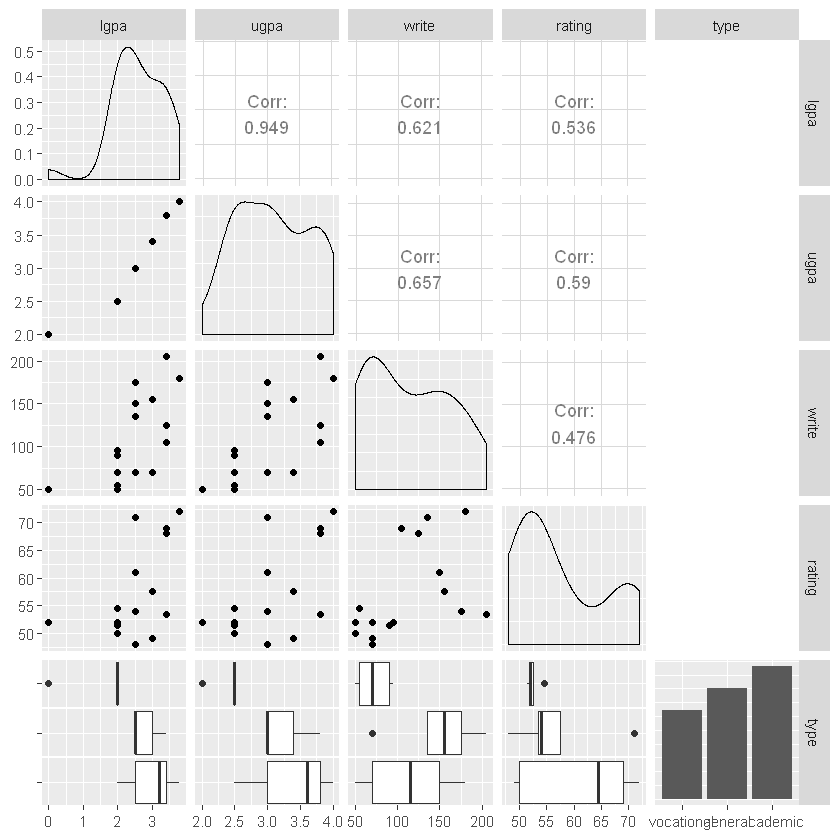

In [4]:
# bivariate plots
ggpairs(dat[, -1], lower = list(combo = "box"), upper = list(combo = "blank"))

In [5]:
by(dat[, 2:5], dat$type, colMeans, na.rm = TRUE)

dat$type: vocational
   lgpa    ugpa   write  rating 
 1.7500  2.4375 71.8750 52.5000 
------------------------------------------------------------ 
dat$type: general
  lgpa   ugpa  write rating 
  2.78   3.24 148.00  56.80 
------------------------------------------------------------ 
dat$type: academic
      lgpa       ugpa      write     rating 
  3.016667   3.416667 113.333333  61.500000 

### Analysis methods you might consider

### Interval regression

In [6]:
# setup the survival object with interval censoring
(Y <- with(dat, Surv(lgpa, ugpa, event = rep(3, nrow(dat)), type = "interval")))

 [1] [2.5, 3.0] [3.4, 3.8] [2.5, 3.0] [0.0, 2.0] [3.0, 3.4] [3.4, 3.8]
 [7] [3.8, 4.0] [2.0, 2.5] [3.0, 3.4] [3.4, 3.8] [2.0, 2.5] [2.0, 2.5]
[13] [2.0, 2.5] [2.5, 3.0] [2.5, 3.0] [2.5, 3.0] [3.4, 3.8] [2.5, 3.0]
[19] [2.0, 2.5] [3.0, 3.4] [3.4, 3.8] [3.8, 4.0] [2.0, 2.5] [3.0, 3.4]
[25] [3.4, 3.8] [2.0, 2.5] [2.0, 2.5] [2.0, 2.5] [2.5, 3.0] [2.5, 3.0]

In [7]:
m <- survreg(Y ~ write + rating + type, data = dat, dist = "gaussian")
summary(m)


Call:
survreg(formula = Y ~ write + rating + type, data = dat, dist = "gaussian")
                Value Std. Error     z       p
(Intercept)   1.10386    0.44529  2.48  0.0132
write         0.00528    0.00169  3.12  0.0018
rating        0.01331    0.00912  1.46  0.1443
typegeneral   0.37485    0.19275  1.94  0.0518
typeacademic  0.70975    0.16684  4.25 2.1e-05
Log(scale)   -1.23726    0.15964 -7.75 9.2e-15

Scale= 0.29 

Gaussian distribution
Loglik(model)= -33.1   Loglik(intercept only)= -51.7
	Chisq= 37.24 on 4 degrees of freedom, p= 1.6e-07 
Number of Newton-Raphson Iterations: 5 
n= 30 


In [8]:
# analysis of deviance table
anova(m)

,Df,Deviance,Resid. Df,-2*LL,Pr(>Chi)
NULL,NA,NA,28,103.49458,NA
write,1,16.68911,27,86.80546,0.0000440330
rating,1,6.09718,26,80.70828,0.0135397767
type,2,14.45047,24,66.25781,0.0007279805


In [9]:
# for the regression surface
f <- function(x, y, type = "vocational") {
      newdat <- data.frame(write = x, rating = y, type = factor(type, levels = levels(dat$type)))
      predict(m, newdata = newdat)  }

# Create X, Y, and Z grids
X <- with(dat, seq(from = min(write), to = max(write), length.out = 10))
Y <- with(dat, seq(from = min(rating), to = max(rating), length.out = 10))
Z <- outer(X, Y, f)

# Create 3d scatter plot and add the regression surface
open3d(windowRect = c(100, 100, 700, 700))

wgl 
  1

In [10]:
with(dat, plot3d(x = write, y = rating, z = ugpa, xlab = "write", ylab = "rating", 
     zlab = "ugpa", xlim = range(write), ylim = range(rating), zlim = range(ugpa)))
par3d(ignoreExtent = TRUE)

# add regression surface for each type of program in a different colour
# with 50 percent transparency (alpha = .5)
surface3d(X, Y, outer(X, Y, f, type = "vocational"), col = "blue", alpha = 0.5)
surface3d(X, Y, outer(X, Y, f, type = "general"), col = "red", alpha = 0.5)
surface3d(X, Y, outer(X, Y, f, type = "academic"), col = "green", alpha = 0.5)

# create an animated movie movie3d(spin3d(axis=c(.5,.5,.5), rpm=5), duration=6, dir = 'intreg_fig')

In [11]:
(r <- with(dat, cor(cbind(yhat = predict(m), lgpa, ugpa))))

,yhat,lgpa,ugpa
yhat,1.0000000,0.7945804,0.8430154
lgpa,0.7945804,1.0000000,0.9487806
ugpa,0.8430154,0.9487806,1.0000000


In [12]:
# pseudo R2
r^2

,yhat,lgpa,ugpa
yhat,1.0000000,0.6313580,0.7106749
lgpa,0.6313580,1.0000000,0.9001847
ugpa,0.7106749,0.9001847,1.0000000
